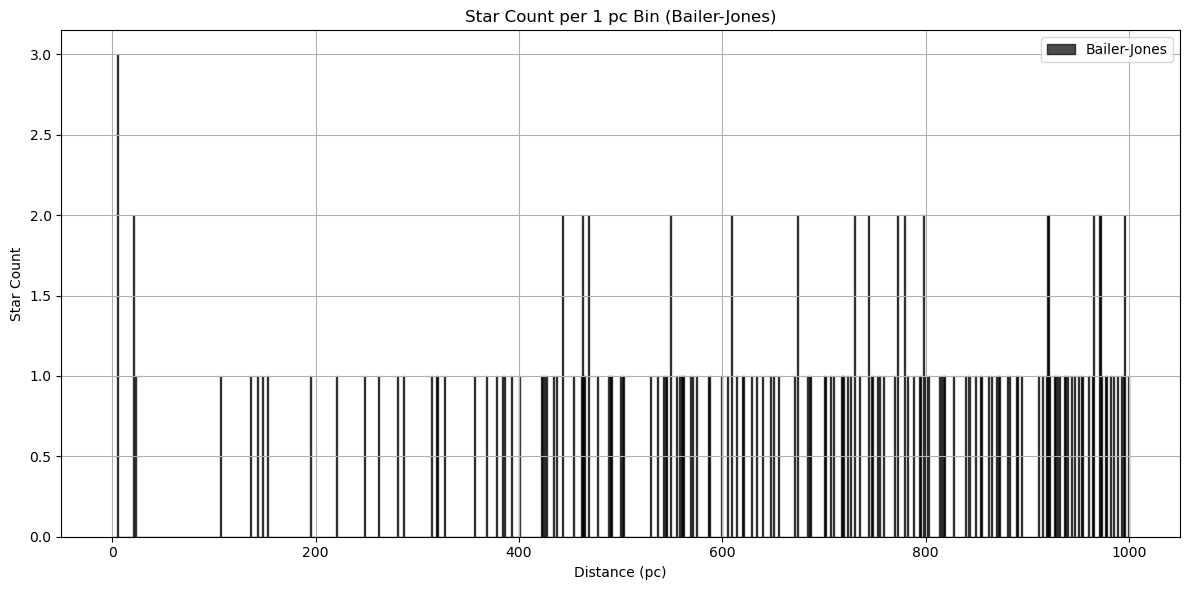

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load saved distances
bj_distances = pd.read_csv("bj_distances_under_1kpc.csv")['r_med_photogeo']

# Create overlayed histogram
plt.figure(figsize=(12, 6))
bins = range(0, 1001, 1)

plt.hist(bj_distances, bins=bins, color='black', alpha=0.7, label='Bailer-Jones', edgecolor='black')

plt.xlabel('Distance (pc)')
plt.ylabel('Star Count')
plt.title('Star Count per 1 pc Bin (Bailer-Jones)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

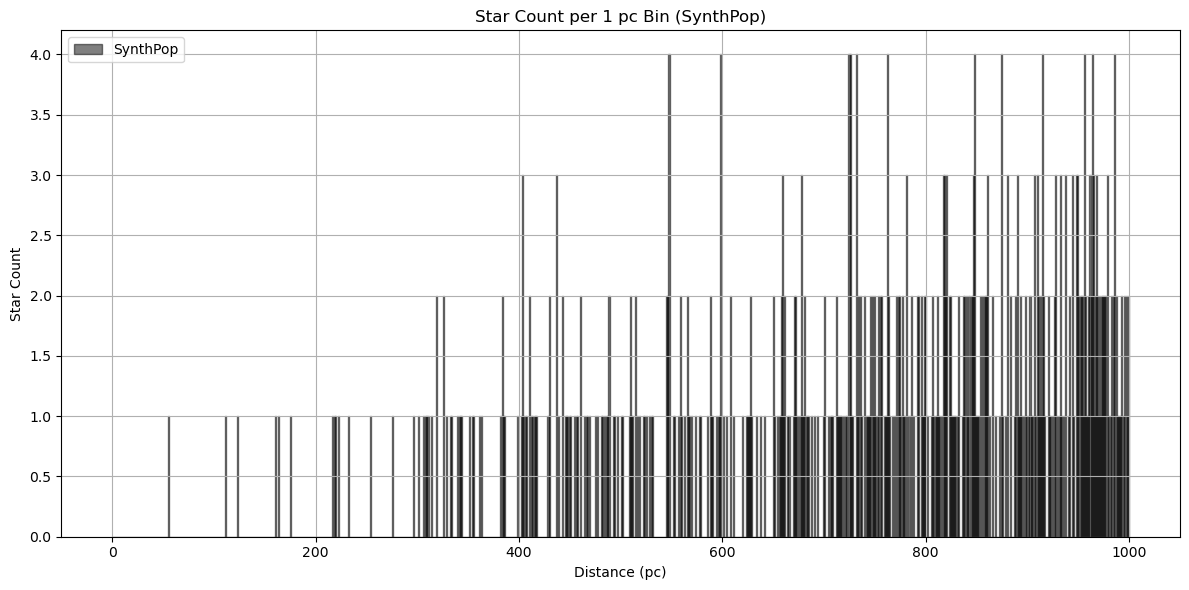

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load saved distances
synth_distances = pd.read_csv("SynthPop/synthpop_distances_under_1kpc.csv")['Dist_pc']

# Create overlayed histogram
plt.figure(figsize=(12, 6))
bins = range(0, 1001, 1)

plt.hist(synth_distances, bins=bins, color='black', alpha=0.5, label='SynthPop', edgecolor='black')

plt.xlabel('Distance (pc)')
plt.ylabel('Star Count')
plt.title('Star Count per 1 pc Bin (SynthPop)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import pandas as pd

# Define 200 pc bins from 0 to 1000
bins = np.arange(0, 1001, 200)

# Bin the data and get counts
bj_counts, _ = np.histogram(bj_distances, bins=bins)
synth_counts, _ = np.histogram(synth_distances, bins=bins)

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Create comparison table
comparison_df = pd.DataFrame({
    'Distance_bin_pc': bin_centers,
    'BailerJones_count': bj_counts,
    'SynthPop_count': synth_counts
})

# Difference between SynthPop and Bailer-Jones counts
comparison_df['Difference (SynthPop - BailerJones)'] = (
    comparison_df['SynthPop_count'] - comparison_df['BailerJones_count']
)

# Optional: sort by magnitude of difference
comparison_df_sorted = comparison_df.sort_values(by='Difference (SynthPop - BailerJones)', ascending=False)
comparison_df_sorted

,Distance_bin_pc,BailerJones_count,SynthPop_count,Difference (SynthPop - BailerJones)
4,900.0,61,244,183
3,700.0,49,153,104
2,500.0,42,101,59
1,300.0,15,36,21
0,100.0,12,6,-6


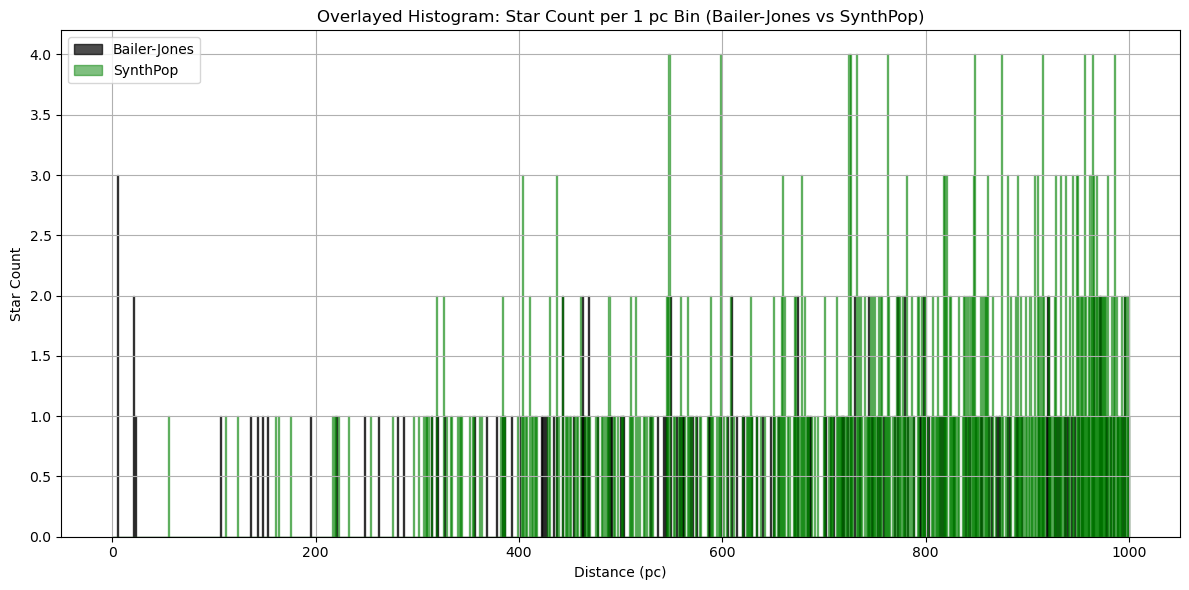

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load saved distances
bj_distances = pd.read_csv("bj_distances_under_1kpc.csv")['r_med_photogeo']
synth_distances = pd.read_csv("SynthPop/synthpop_distances_under_1kpc.csv")['Dist_pc']

# Create overlayed histogram
plt.figure(figsize=(12, 6))
bins = range(0, 1001, 1)

plt.hist(bj_distances, bins=bins, color='black', alpha=0.7, label='Bailer-Jones', edgecolor='black')
plt.hist(synth_distances, bins=bins, color='green', alpha=0.5, label='SynthPop', edgecolor='green')

plt.xlabel('Distance (pc)')
plt.ylabel('Star Count')
plt.title('Overlayed Histogram: Star Count per 1 pc Bin (Bailer-Jones vs SynthPop)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import synthpop
from scipy.stats import gaussian_kde
from astropy.table import Table
import pandas as pd
import synthpop
from scipy.stats import gaussian_kde

def angular_separation_arcmin(ra1, dec1, ra2, dec2):
    """
    Compute angular separation between two points (RA/Dec, degrees) in arcminutes.
    All inputs and output are floats.
    """
    c1 = SkyCoord(ra1, dec1, unit='deg')
    c2 = SkyCoord(ra2, dec2, unit='deg')
    sep = c1.separation(c2)
    return sep.arcminute  # Output: float, arcminutes

def beam_scaling(beam_ra, beam_dec, star_ra, star_dec, fwhm_arcmin):
    """
    Calculate angular separation and Gaussian beam scaling factor for a star.
    All coordinates in degrees, FWHM and output in arcminutes.
    Returns: (theta_arcmin: angular separation between star and beam center, scaling_factor: normalized sensitivity of the star, 
    eirp_boost: how many times larger the EIRPmin of the star must be than the beam's center)
    """
    theta_arcmin = angular_separation_arcmin(beam_ra, beam_dec, star_ra, star_dec)
    exponent = -4 * np.log(2) * (theta_arcmin / fwhm_arcmin)**2
    scaling_factor = np.exp(exponent)
    eirp_boost = np.where(scaling_factor > 0, 1.0 / scaling_factor, np.inf)
    return theta_arcmin, scaling_factor, eirp_boost

def process_beam_astropy_vectorized(beam_ra, beam_dec, fwhm_arcmin, catalog_df):
    """
    Add beam sensitivity columns to existing DataFrame
    Inputs:
        beam_ra, beam_dec: Beam center (degrees)
        fwhm_arcmin: Beam width (arcminutes)
        catalog_df: DataFrame containing 'ra', 'dec'
    Returns: Modified DataFrame with new columns using SkyCoord
    Vectorized processing for large catalogs.
    """
    # Extract RA/Dec as numpy arrays
    star_ras = catalog_df['ra'].to_numpy()
    star_decs = catalog_df['dec'].to_numpy()
    
    # Compute metrics in bulk
    theta, scaling, eirp = beam_scaling(
        beam_ra, beam_dec, star_ras, star_decs, fwhm_arcmin
    )
    
    # Add results to DataFrame (no copying)
    catalog_df = catalog_df.copy()
    catalog_df['theta_arcmin'] = theta
    catalog_df['scaling_factor'] = scaling
    catalog_df['eirp_boost'] = eirp
    
    return catalog_df

/Users/MattLor/opt/anaconda3/lib/python3.13/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'keep_untouched' has been renamed to 'ignored_types'
  warnings.warn(message, UserWarning)


# Gaia

In [6]:
from astroquery.gaia import Gaia
Gaia.login(user='mweiss', password='Laughsalot2!')

INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]


In [20]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u

Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"
Gaia.ROW_LIMIT = -1  # remove row limit

def query_gaia(ra_deg, dec_deg, fwhm_arcmin):
    # Convert FWHM to search radius in degrees
    radius_deg = (fwhm_arcmin / 2.0) / 60.0

    # Build ADQL query using user input coordinates
    query = f"""
    SELECT
      source_id, ra, dec,
      r_med_geo, r_lo_geo, r_hi_geo,
      r_med_photogeo, r_lo_photogeo, r_hi_photogeo,
      phot_bp_mean_mag - phot_rp_mean_mag AS bp_rp,
      phot_g_mean_mag,
      phot_g_mean_mag - 5 * LOG10(r_med_geo) + 5 AS abs_g_geo,
      phot_g_mean_mag - 5 * LOG10(r_med_photogeo) + 5 AS abs_g_photogeo
    FROM (
        SELECT * FROM gaiaedr3.gaia_source
        WHERE 1 = CONTAINS(
          POINT('ICRS', {ra_deg}, {dec_deg}),
          CIRCLE('ICRS', ra, dec, {radius_deg})
        )
    ) AS edr3
    JOIN external.gaiaedr3_distance USING (source_id)
    WHERE ruwe < 1.4
    """

    job = Gaia.launch_job_async(query)
    result = job.get_results().to_pandas()
    result = process_beam_astropy_vectorized(ra_deg, dec_deg, fwhm_arcmin, result)
    return result

# NED

In [21]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.ipac.ned import Ned

def query_ned(beam_ra, beam_dec, fwhm_arcmin):
    result_table = Ned.query_region(SkyCoord(ra=beam_ra*u.deg, dec=beam_dec*u.deg), radius=(fwhm_arcmin/2.0)*u.arcmin)
    df = result_table.to_pandas()
    df = df.rename(columns={"RA": "ra", "DEC": "dec"})
    return process_beam_astropy_vectorized(beam_ra, beam_dec, fwhm_arcmin, df)

# SynthPop

In [22]:
def query_synthpop(ra_deg, dec_deg, fwhm_arcmin, config_file='my_config.synthpop_conf'):
    """
    Generate SynthPop star catalog from RA/Dec + radius (in arcmin).

    Parameters:
    - ra_deg (float): Right Ascension in degrees
    - dec_deg (float): Declination in degrees
    - fwhm_arcmin (float): FWHM in arcminutes
    - config_file (str): path to SynthPop config file

    Returns:
    - region_synth (pd.DataFrame): SynthPop star catalog in a pandas DataFrame
    """
    # Convert RA/Dec to Galactic l,b
    coord = SkyCoord(ra=ra_deg * u.deg, dec=dec_deg * u.deg, frame='icrs')
    l = coord.galactic.l.deg
    b = coord.galactic.b.deg

    # Convert FWHM to radius and from arcmin to deg, then compute solid angle in deg²
    radius_deg = (fwhm_arcmin / 2) / 60
    solid_angle_deg2 = np.pi * radius_deg**2
    print(solid_angle_deg2)

    # Initialize SynthPop
    mod = synthpop.SynthPop('huston2025_defaults.synthpop_conf',
                         extinction_map_kwargs={'name':'maps_from_dustmaps', 'dustmap_name': 'sfd'},
                         chosen_bands = ['Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', "Gaia_G_EDR3", "Gaia_BP_EDR3", "Gaia_RP_EDR3"],
                         maglim = ['Bessell_I', 99, "keep"],
                         post_processing_kwargs=[{"name": "ProcessDarkCompactObjects","remove": False}, 
                        {"name":"equatorial_coordinates"}],
                         name_for_output='mod2test'
                        )
    mod.init_populations()

    # Run catalog simulation
    cat, distr = mod.process_location(l_deg=l, b_deg=b,
                                  solid_angle=solid_angle_deg2,
                                  solid_angle_unit='deg^2')
    cat["Dist_pc"] = cat["Dist"] * 1000
    cat = process_beam_astropy_vectorized(ra_deg, dec_deg, fwhm_arcmin, cat)
    return cat

In [23]:
def generate_full_beam_catalog(beam_ra, beam_dec, fwhm_arcmin):
    gaia_df = query_gaia(beam_ra, beam_dec, fwhm_arcmin) 
    synth_df = query_synthpop(beam_ra, beam_dec, fwhm_arcmin) 
    ned_df = query_ned(beam_ra, beam_dec, fwhm_arcmin)

    return gaia_df, synth_df, ned_df

# Region 7 from VOTable

In [24]:
# Load the VOTable
votable_path = "356616_observations_288315_unique_280820.vot"
data_table = Table.read(votable_path, format="votable")
df = data_table.to_pandas()
df

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_over_error,pmra,pmra_error,pmdec,...,r_hi,r_len,target_observed_by,source_observed_by,fwhm_arcmin,offset_deg,offset_arcmin,telescope_response_gaussian,min_detectable_EIRP,price_target_
0,5278042880077383040,124.373564,0.531406,-61.916283,0.577067,191.530069,317.248718,-156.445708,1.257197,1099.603065,...,5.237054,854.145623,Parkes 10-cm,Parkes 10-cm,6.4,0.004946,0.296757,0.994057,9.979345e+10,True
1,5278019446732658176,124.323083,0.683469,-61.933165,0.722185,0.288692,0.386957,-9.208477,1.665850,4.106262,...,3424.169938,852.574779,Parkes 10-cm,Parkes 10-cm,6.4,0.053314,3.198850,0.500249,2.571122e+16,False
2,5278042914437037440,124.321704,0.017173,-61.921527,0.019508,0.306640,15.678685,1.455955,0.039321,-3.939431,...,3149.749330,852.831089,Parkes 10-cm,Parkes 10-cm,6.4,0.053294,3.197619,0.500516,6.391667e+16,False
3,5277995665498104576,124.405225,0.123812,-61.964518,0.137092,0.162447,1.190629,2.031666,0.288846,-0.058157,...,4666.506808,853.656804,Parkes 10-cm,Parkes 10-cm,6.4,0.052973,3.178368,0.504692,7.781783e+16,False
4,5277996009096662912,124.427643,0.465830,-61.920097,0.409031,0.134454,0.301610,-3.008525,1.080743,5.900701,...,3767.438101,855.297497,Parkes 10-cm,Parkes 10-cm,6.4,0.052656,3.159362,0.508823,3.617772e+16,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356611,5353625817648324352,162.327898,0.169651,-53.323989,0.188827,0.002797,0.012486,-7.121278,0.332859,4.258981,...,6063.476843,1216.497976,Parkes 10-cm,Parkes 10-cm,6.4,0.004614,0.276850,0.994825,5.451843e+16,False
356612,5353625847691839616,162.331233,0.148051,-53.317264,0.161793,0.107848,0.543369,-6.472833,0.280615,0.680678,...,5731.854286,1216.642346,Parkes 10-cm,Parkes 10-cm,6.4,0.003272,0.196336,0.997394,4.785815e+16,False
356613,5353625817648467840,162.328145,0.401868,-53.322196,0.451638,-0.629335,-1.170949,-5.444157,0.841270,1.893667,...,5795.023651,1216.522702,Parkes 10-cm,Parkes 10-cm,6.4,0.002810,0.168584,0.998078,4.466139e+16,False
356614,5353625847691839488,162.328315,0.037486,-53.318426,0.041577,0.150904,3.040733,-4.872873,0.072231,1.066499,...,6255.618265,1216.567137,Parkes 10-cm,Parkes 10-cm,6.4,0.001153,0.069207,0.999676,8.723952e+16,False


In [25]:
df_small = df.loc[[0, 500, 5000, 50000, 100000, 200000, 300000], ["ra", "dec", "fwhm_arcmin", "r_est"]].copy()
df_small

,ra,dec,fwhm_arcmin,r_est
0,124.373564,-61.916283,6.4,5.220425
500,235.157257,-50.986211,6.4,3569.674987
5000,6.639102,-41.840455,6.4,1038.977856
50000,337.162703,18.968371,8.4,2186.465647
100000,104.347052,-24.647317,6.4,3370.492664
200000,264.242801,-44.312320,5.5,3672.485895
300000,296.382669,33.565181,5.5,2411.655322


In [26]:
gaia_df, synth_df, ned_df = generate_full_beam_catalog(296.382669, 33.565181, 5.5)



################################ Settings #################################
 323564 - # reading default parameters from
 323566 - default_config_file =  /Users/MattLor/synthpop/synthpop/config_files/_default.synthpop_conf 
 323567 - # read configuration from 
 323567 - config_file = '/Users/MattLor/synthpop/synthpop/config_files/huston2025_defaults.synthpop_conf' 


# copy the following to a config file to redo this model generation -------
 323568 - {
    "l_set": null,
    "l_set_type": null,
    "b_set": null,
    "b_set_type": null,
    "name_for_output": "mod2test",
    "model_name": "Huston2025",
    "solid_angle": null,
    "solid_angle_unit": "deg^2",
    "random_seed": 1070897814,
    "sun": {
        "x": -8.178,
        "y": 0.0,
        "z": 0.017,
        "u": 12.9,
        "v": 245.6,
        "w": 7.78,
        "l_apex_deg": 56.24,
        "b_apex_deg": 22.54
    },
    "lsr": {
        "u_lsr": 1.8,
        "v_lsr": 233.4,
        "w_lsr": 0.53
    },
    "warp": {
   

INFO: Query finished. [astroquery.utils.tap.core]
0.006599526234103557




# Population 1;  halo -----------------------------------------------------
 324268 - # Initialize Population 1 (halo) from 
 324268 - pop_file = '/Users/MattLor/synthpop/synthpop/models/Huston2025/halo.popjson'


# Population 2;  nsd ------------------------------------------------------
 324876 - # Initialize Population 2 (nsd) from 
 324876 - pop_file = '/Users/MattLor/synthpop/synthpop/models/Huston2025/nsd.popjson'


# Population 3;  thick_disk -----------------------------------------------
 325909 - # Initialize Population 3 (thick_disk) from 
 325909 - pop_file = '/Users/MattLor/synthpop/synthpop/models/Huston2025/thick_disk.popjson'


# Population 4;  thin_disk_1 ----------------------------------------------
 326476 - # Initialize Population 4 (thin_disk_1) from 
 326476 - pop_file = '/Users/MattLor/synthpop/synthpop/models/Huston2025/thin_disk_1.popjson'


# Population 5;  thin_disk_2 ----------------------------------------------
 327048 - # Initialize Population 5 (thin_

In [27]:
gaia_df

,source_id,ra,dec,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,bp_rp,phot_g_mean_mag,abs_g_geo,abs_g_photogeo,theta_arcmin,scaling_factor,eirp_boost
0,2035014298680399488,296.347503,33.529946,4956.104492,3056.981201,7387.973145,8577.018555,7220.299316,10573.769531,1.225140,20.236704,6.761002,5.570022,2.749881,0.500030,1.999880
1,2035014500526648192,296.341079,33.536024,6389.452637,4246.988281,9009.046875,6771.067383,5446.024414,8887.122070,1.151920,19.260746,5.233428,5.107460,2.717628,0.508178,1.967816
2,2035014504837478784,296.339137,33.537259,3815.895508,2064.510498,5885.988770,15274.573242,12260.625977,20087.054688,1.012239,20.734112,7.826129,4.814266,2.746836,0.500798,1.996814
3,2035014504838838784,296.344319,33.532986,6554.446289,2750.245850,10077.131836,17921.164062,14955.580078,21700.318359,0.868629,20.776806,6.694126,4.509975,2.721960,0.507081,1.972071
4,2035014504839829120,296.340885,33.536839,5772.882812,3357.548584,11971.694336,7489.538574,6196.681641,10260.411133,1.305304,20.149691,6.342727,5.777415,2.693906,0.514192,1.944798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,2035008938581804288,296.435836,33.568661,1074.651245,1022.424072,1128.448364,1096.186523,1045.344238,1168.669556,1.385380,16.844030,6.687693,6.644608,2.666250,0.521226,1.918553
1900,2035008938581809664,296.426340,33.563956,3641.557861,3037.187012,4431.803223,3378.341797,2913.433105,3922.358643,1.047991,16.979517,4.173081,4.335999,2.184611,0.645694,1.548721
1901,2035008938581809792,296.425090,33.567814,1455.467896,1424.806641,1483.666870,1451.667480,1428.430176,1477.312378,0.227984,12.228110,1.413097,1.418775,2.126723,0.660634,1.513697
1902,2035008938581824128,296.430227,33.557797,1992.514648,1917.206421,2081.410889,1953.840332,1881.893555,2028.619263,0.860988,14.984699,3.487692,3.530254,2.418685,0.584973,1.709482


In [28]:
synth_df

,pop,iMass,age,Fe/H_initial,Mass,In_Final_Phase,Dist,ra,dec,vr_bc,...,Bessell_R,Bessell_I,Gaia_G_EDR3,Gaia_BP_EDR3,Gaia_RP_EDR3,Dim_Compact_Object_Flag,Dist_pc,theta_arcmin,scaling_factor,eirp_boost
0,0.0,0.258981,10.000000,0.172152,0.258977,0.0,2.304841,296.432007,33.568863,91.952731,...,25.044582,22.968323,24.823030,27.088561,23.220127,0.0,2304.840591,2.476501,0.569994,1.754406
1,0.0,0.225304,10.000000,0.136073,0.225301,0.0,2.825339,296.404985,33.577649,-71.113543,...,25.850791,23.753084,25.608455,27.936062,23.997384,0.0,2825.338579,1.343227,0.847579,1.179831
2,0.0,0.427146,10.000000,-0.002382,0.427136,0.0,3.403819,296.349726,33.542729,-31.014018,...,23.380777,21.879786,23.479813,25.052112,22.108918,0.0,3403.818553,2.127929,0.660324,1.514409
3,0.0,0.496132,10.000000,0.002717,0.496117,0.0,3.623803,296.391433,33.524754,49.946717,...,22.901401,21.514202,23.046590,24.530694,21.722600,0.0,3623.802854,2.464891,0.572999,1.745205
4,0.0,0.404243,10.000000,0.094227,0.404235,0.0,3.874068,296.340978,33.550233,138.235131,...,24.062075,22.419577,24.092626,25.784935,22.667416,0.0,3874.067657,2.269285,0.623756,1.603190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39817,10.0,0.393340,9.816897,-0.185782,0.393331,0.0,24.810263,296.375288,33.544310,-252.054357,...,27.745883,26.324193,27.879983,29.404716,26.536608,0.0,24810.263130,1.305516,0.855375,1.169078
39818,10.0,0.094051,7.927878,-0.346029,0.094051,0.0,24.955579,296.402569,33.597922,-251.449002,...,NaN,NaN,NaN,NaN,NaN,0.0,24955.579386,2.201926,0.641215,1.559540
39819,10.0,0.175978,9.789717,-0.181730,0.175975,0.0,24.961544,296.354160,33.569158,-246.807520,...,30.004702,28.258906,29.994567,31.819910,28.518946,0.0,24961.543842,1.445127,0.825791,1.210960
39820,10.0,0.424295,9.213073,-0.368047,0.424285,0.0,24.913853,296.393282,33.583826,-167.966244,...,27.274273,25.991801,27.459218,28.881691,26.175691,0.0,24913.852954,1.238139,0.868917,1.150857


In [29]:
ned_df

,No.,Object Name,ra,dec,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations,theta_arcmin,scaling_factor,eirp_boost
0,1,2MASS J19451894+3333376,296.32894,33.56045,IrS,NaN,NaN,,,2.702,0,0,4,1,0,0,0,2.701235,0.512332,1.951859
1,2,WISEA J194518.97+333353.4,296.32904,33.56485,IrS,NaN,NaN,,,2.681,0,0,18,2,0,0,0,2.681284,0.517400,1.932742
2,3,2MASS J19451900+3333209,296.32918,33.55583,IrS,NaN,NaN,,,2.733,0,0,4,1,0,0,0,2.732571,0.504398,1.982560
3,4,WISEA J194519.29+333423.2,296.33040,33.57313,IrS,NaN,NaN,,,2.657,0,0,18,2,0,0,0,2.656260,0.523773,1.909226
4,5,2MASS J19451932+3333363,296.33053,33.56010,IrS,NaN,NaN,,,2.625,0,0,6,1,0,0,0,2.624555,0.531872,1.880150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,483,WISEA J194543.71+333454.2,296.43216,33.58174,IrS,NaN,NaN,,,2.666,0,0,18,2,0,0,0,2.666126,0.521258,1.918437
483,484,WISEA J194544.19+333310.1,296.43412,33.55289,IrS,NaN,NaN,,,2.676,0,0,18,2,0,0,0,2.676116,0.518714,1.927843
484,485,2MASS J19454457+3333167,296.43574,33.55464,IrS,NaN,NaN,,,2.727,0,0,5,1,0,0,0,2.727803,0.505603,1.977835
485,486,2MASS J19454461+3334072,296.43588,33.56869,IrS,NaN,NaN,,,2.668,0,0,6,1,0,0,0,2.668572,0.520635,1.920732


# Comparison of Gaia and SynthPop EIRPmin, N*, CWTFM, and Transmitter Rate for Region 7

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from scipy.optimize import minimize

def process_gaia_catalog(gaia_df, beam_ra, beam_dec, fwhm_arcmin, fmin, nu_rel, log_eirp_shells=np.linspace(11, 18, 8)):
    """
    Process Gaia catalog with Bailer-Jones distances for SETI beam analysis.
    
    Parameters:
    -----------
    gaia_df : pandas.DataFrame
        Gaia catalog with columns 'ra', 'dec', 'r_lo_geo', 'r_med_geo', 'r_hi_geo'
    beam_ra, beam_dec : float
        Beam center coordinates (degrees)
    fwhm_arcmin : float
        Beam full width at half maximum (arcminutes)
    fmin : float
        Minimum detectable flux (W/m²)
    nu_rel : float
        Fractional bandwidth
    log_eirp_shells : list
        Bin edges for EIRPmin shells in *logspace*
        default list np.linspace(11, 18, 8), 8 shells
        
    Returns: Update this!!!!!!
    --------
    dict
        Dictionary with processed catalog and shell analysis
    """
    # 1. Calculate beam sensitivity metrics
    def angular_separation_arcmin(ra1, dec1, ra2, dec2):
        """
        Compute angular separation between two points (RA/Dec, degrees) in arcminutes.
        All inputs and output are floats.
        """
        c1 = SkyCoord(ra1, dec1, unit='deg')
        c2 = SkyCoord(ra2, dec2, unit='deg')
        sep = c1.separation(c2)
        return sep.arcminute  # Output: float, arcminutes
    
    def beam_scaling(beam_ra, beam_dec, star_ra, star_dec, fwhm_arcmin):
        """
        Calculate angular separation and Gaussian beam scaling factor for a star.
        All coordinates in degrees, FWHM and output in arcminutes.
        Returns: (theta_arcmin: angular separation between star and beam center, scaling_factor: normalized sensitivity of the star, 
        eirp_boost: how many times larger the EIRPmin of the star must be than the beam's center)
        """
        theta_arcmin = angular_separation_arcmin(beam_ra, beam_dec, star_ra, star_dec)
        exponent = -4 * np.log(2) * (theta_arcmin / fwhm_arcmin)**2
        scaling_factor = np.exp(exponent)
        eirp_boost = np.where(scaling_factor > 0, 1.0 / scaling_factor, np.inf)
        return theta_arcmin, scaling_factor, eirp_boost
    
    def process_beam_astropy_vectorized(beam_ra, beam_dec, fwhm_arcmin, catalog_df):
        """
        Add beam sensitivity columns to existing DataFrame
        Inputs:
            beam_ra, beam_dec: Beam center (degrees)
            fwhm_arcmin: Beam width (arcminutes)
            catalog_df: DataFrame containing 'ra', 'dec'
        Returns: Modified DataFrame with new columns using SkyCoord
        Vectorized processing for large catalogs.
        """
        # Always work on a copy!
        catalog_df = catalog_df.copy()
        # Extract RA/Dec as numpy arrays
        star_ras = catalog_df['ra'].to_numpy()
        star_decs = catalog_df['dec'].to_numpy()
        
        # Compute metrics in bulk
        theta, scaling, eirp = beam_scaling(
        beam_ra, beam_dec, star_ras, star_decs, fwhm_arcmin)
        
        # Add results to DataFrame (no copying)
        catalog_df = catalog_df.copy()
        catalog_df.loc[:, 'theta_arcmin'] = theta
        catalog_df.loc[:, 'scaling_factor'] = scaling
        catalog_df.loc[:, 'eirp_boost'] = eirp
        return catalog_df

    gaia_df = process_beam_astropy_vectorized(beam_ra, beam_dec, fwhm_arcmin, gaia_df)

    # Calculate EIRPmin for median, low, high distances
    def calculate_eirpmin_log(df, fmin):
        df = df.copy()
        # Calculate log10(EIRPmin) = log10(4*pi) + 2*log10(d) + log10(fmin) + log10(eirp_boost)
        log_4pi = np.log10(4 * np.pi)
        for key, col in zip(['med', 'lo', 'hi'], ['r_med_geo', 'r_lo_geo', 'r_hi_geo']):
            d_m = df[col].to_numpy() * 3.086e16
            df[f'logEIRPmin_{key}'] = log_4pi + 2 * np.log10(d_m) + np.log10(fmin) + np.log10(df['eirp_boost'])
        return df
    gaia_df = calculate_eirpmin_log(gaia_df, fmin)

    # # Fit skew normal parameters for each star (optional for future PDF work)
    # skew_params = df.apply(lambda row: fit_skewnorm(row['r_lo_geo'], row['r_med_geo'], row['r_hi_geo']), axis=1, result_type='expand')
    # skew_params.columns = ['a', 'loc', 'scale']
    # df = pd.concat([df, skew_params], axis=1)

    # # Define cumulative EIRPmin shells (matching Table 2 of the paper)
    # eirp_shells = np.logspace(11, 18, 8)  # 1e11 to 1e18, 8 shells

    # Analyze shells with cumulative counting and errors
    def analyze_shells_with_uncertainty_cumulative_log_gaia(df, log_eirp_shells, fmin, nu_rel):
        results = []
        for log_shell_val in log_eirp_shells:
            shell_val = 10**log_shell_val
            n_stars = np.sum(df['logEIRPmin_med'] <= log_shell_val)
            pos_err = np.sum((df['logEIRPmin_med'] > log_shell_val) & (df['logEIRPmin_lo'] <= log_shell_val))
            neg_err = np.sum((df['logEIRPmin_med'] <= log_shell_val) & (df['logEIRPmin_hi'] > log_shell_val))
            cwtfm = (shell_val / 1e13) * (0.5 / nu_rel) * (1000 / n_stars) if n_stars > 0 else np.nan
    
            n_stars_lower = n_stars - neg_err if (n_stars - neg_err) > 0 else np.nan
            cwtfm_pos = (shell_val / 1e13) * (0.5 / nu_rel) * (1000 / n_stars_lower) if n_stars_lower > 0 else np.nan
            cwtfm_pos_err = cwtfm_pos - cwtfm if n_stars_lower > 0 else np.nan
    
            n_stars_upper = n_stars + pos_err if (n_stars + pos_err) > 0 else np.nan
            cwtfm_neg = (shell_val / 1e13) * (0.5 / nu_rel) * (1000 / n_stars_upper) if n_stars_upper > 0 else np.nan
            cwtfm_neg_err = cwtfm - cwtfm_neg if n_stars_upper > 0 else np.nan
    
            results.append({
                'EIRPmin_shell': shell_val,
                'n_stars': n_stars,
                'n_stars_pos_err': pos_err,
                'n_stars_neg_err': neg_err,
                'CWTFM': cwtfm,
                'CWTFM_pos_err': cwtfm_pos_err,
                'CWTFM_neg_err': cwtfm_neg_err
            })
        return pd.DataFrame(results)
    shell_results_gaia = analyze_shells_with_uncertainty_cumulative_log_gaia(gaia_df, log_eirp_shells, fmin, nu_rel)
    return gaia_df, shell_results_gaia

    # my_dict = {'processed_catalog': gaia_df, 'shell_analysis': shell_results}
    # return my_dict

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def plot_transmitter_rate_vs_eirpmin_gaia(shell_results, nu_rel=0.5):
    """
    Plot log(Transmitter Rate) vs log(EIRPmin) with asymmetric error bars,
    best-fit line, and vertical reference lines at log(EIRPmin)=13,17.
    """
    # Extract data
    eirp_shells = shell_results['EIRPmin_shell'].to_numpy()
    n_stars = shell_results['n_stars'].to_numpy()
    n_stars_pos_err = shell_results['n_stars_pos_err'].to_numpy()
    n_stars_neg_err = shell_results['n_stars_neg_err'].to_numpy()

    # Calculate transmitter rate and its errors
    transmitter_rate = 1.0 / (n_stars * nu_rel)
    n_stars_lower = n_stars - n_stars_neg_err
    n_stars_upper = n_stars + n_stars_pos_err

    # Avoid division by zero or negative counts
    transmitter_rate_pos = np.where(n_stars_lower > 0, 1.0 / (n_stars_lower * nu_rel), np.nan)
    transmitter_rate_neg = np.where(n_stars_upper > 0, 1.0 / (n_stars_upper * nu_rel), np.nan)

    # Asymmetric errors
    yerr_pos = transmitter_rate_pos - transmitter_rate
    yerr_neg = transmitter_rate - transmitter_rate_neg

    # Log values for plotting
    log_eirp = np.log10(eirp_shells)
    log_transmitter_rate = np.log10(transmitter_rate)
    # For error bars, use differences in log space
    log_yerr_pos = np.log10(transmitter_rate_pos) - log_transmitter_rate
    log_yerr_neg = log_transmitter_rate - np.log10(transmitter_rate_neg)

    # Mask for finite values
    mask = np.isfinite(log_eirp) & np.isfinite(log_transmitter_rate) & (n_stars > 0)
    x = log_eirp[mask]
    y = log_transmitter_rate[mask]
    yerr = np.array([log_yerr_neg[mask], log_yerr_pos[mask]])

    # Fit a line (excluding nan/infs)
    fit = np.polyfit(x, y, 1)
    fit_line = np.polyval(fit, x)

    fig, ax = plt.subplots(figsize=(10, 6))
    # Asymmetric error bars: use yerr as [[neg], [pos]]
    ax.errorbar(
        x, y, yerr=yerr,
        fmt='o', capsize=5, markersize=8, label='WG&S Shells'
    )
    ax.plot(x, fit_line, 'k-', label='Best Fit Line')
    ax.axvline(13, color='red', linestyle='--', lw=2, label='Arecibo Radar (logEIRP=13)')
    ax.axvline(17, color='red', linestyle='--', lw=2, label='Kardashev I (logEIRP=17)')
    ax.set_xlabel('log$_{10}$(EIRP$_{\\mathrm{min}}$/W)', fontsize=12)
    ax.set_ylabel('log$_{10}$(Transmitter Rate)', fontsize=12)
    ax.set_title('Log (Transmitter Rate) vs Log (EIRPmin) [Gaia]', fontsize=14)
    ax.set_xlim(11, 18)
    ax.set_ylim(-9, 3)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [62]:
gaia_df = gaia_df[gaia_df["r_med_geo"].notnull() & gaia_df["r_lo_geo"].notnull() & gaia_df["r_hi_geo"].notnull() & 
    gaia_df["bp_rp"].notnull() & gaia_df["abs_g_photogeo"].notnull() & gaia_df["ra"].notnull() & 
    gaia_df["dec"].notnull()]
gaia_df

,source_id,ra,dec,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,bp_rp,phot_g_mean_mag,abs_g_geo,abs_g_photogeo,theta_arcmin,scaling_factor,eirp_boost,logEIRPmin_med,logEIRPmin_lo,logEIRPmin_hi
0,2035014298680399488,296.347503,33.529946,4956.104492,3056.981201,7387.973145,8577.018555,7220.299316,10573.769531,1.225140,20.236704,6.761002,5.570022,2.749881,0.500030,1.999880,15.769286,15.349593,16.116057
1,2035014500526648192,296.341079,33.536024,6389.452637,4246.988281,9009.046875,6771.067383,5446.024414,8887.122070,1.151920,19.260746,5.233428,5.107460,2.717628,0.508178,1.967816,15.982912,15.628149,16.281344
2,2035014504837478784,296.339137,33.537259,3815.895508,2064.510498,5885.988770,15274.573242,12260.625977,20087.054688,1.012239,20.734112,7.826129,4.814266,2.746836,0.500798,1.996814,15.541531,15.007973,15.917976
3,2035014504838838784,296.344319,33.532986,6554.446289,2750.245850,10077.131836,17921.164062,14955.580078,21700.318359,0.868629,20.776806,6.694126,4.509975,2.721960,0.507081,1.972071,16.005995,15.251669,16.379598
4,2035014504839829120,296.340885,33.536839,5772.882812,3357.548584,11971.694336,7489.538574,6196.681641,10260.411133,1.305304,20.149691,6.342727,5.777415,2.693906,0.514192,1.944798,15.889660,15.418922,16.523186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,2035008938559221376,296.427952,33.569021,3797.693115,1878.210938,6282.960938,19656.035156,15865.251953,22916.738281,0.813936,20.660225,7.762626,4.192745,2.275602,0.622117,1.607415,15.443170,14.831617,15.880457
1899,2035008938581804288,296.435836,33.568661,1074.651245,1022.424072,1128.448364,1096.186523,1045.344238,1168.669556,1.385380,16.844030,6.687693,6.644608,2.666250,0.521226,1.918553,14.423512,14.380238,14.465939
1900,2035008938581809664,296.426340,33.563956,3641.557861,3037.187012,4431.803223,3378.341797,2913.433105,3922.358643,1.047991,16.979517,4.173081,4.335999,2.184611,0.645694,1.548721,15.390551,15.232916,15.561137
1901,2035008938581809792,296.425090,33.567814,1455.467896,1424.806641,1483.666870,1451.667480,1428.430176,1477.312378,0.227984,12.228110,1.413097,1.418775,2.126723,0.660634,1.513697,14.584047,14.565553,14.600713


In [63]:
gaia_df, shell_results_gaia = process_gaia_catalog(gaia_df, 296.382669, 33.565181, 5.5, 1e-26, 0.769, log_eirp_shells=np.linspace(11, 18, 8))

In [64]:
gaia_df

,source_id,ra,dec,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,bp_rp,phot_g_mean_mag,abs_g_geo,abs_g_photogeo,theta_arcmin,scaling_factor,eirp_boost,logEIRPmin_med,logEIRPmin_lo,logEIRPmin_hi
0,2035014298680399488,296.347503,33.529946,4956.104492,3056.981201,7387.973145,8577.018555,7220.299316,10573.769531,1.225140,20.236704,6.761002,5.570022,2.749881,0.500030,1.999880,15.769286,15.349593,16.116057
1,2035014500526648192,296.341079,33.536024,6389.452637,4246.988281,9009.046875,6771.067383,5446.024414,8887.122070,1.151920,19.260746,5.233428,5.107460,2.717628,0.508178,1.967816,15.982912,15.628149,16.281344
2,2035014504837478784,296.339137,33.537259,3815.895508,2064.510498,5885.988770,15274.573242,12260.625977,20087.054688,1.012239,20.734112,7.826129,4.814266,2.746836,0.500798,1.996814,15.541531,15.007973,15.917976
3,2035014504838838784,296.344319,33.532986,6554.446289,2750.245850,10077.131836,17921.164062,14955.580078,21700.318359,0.868629,20.776806,6.694126,4.509975,2.721960,0.507081,1.972071,16.005995,15.251669,16.379598
4,2035014504839829120,296.340885,33.536839,5772.882812,3357.548584,11971.694336,7489.538574,6196.681641,10260.411133,1.305304,20.149691,6.342727,5.777415,2.693906,0.514192,1.944798,15.889660,15.418922,16.523186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,2035008938559221376,296.427952,33.569021,3797.693115,1878.210938,6282.960938,19656.035156,15865.251953,22916.738281,0.813936,20.660225,7.762626,4.192745,2.275602,0.622117,1.607415,15.443170,14.831617,15.880457
1899,2035008938581804288,296.435836,33.568661,1074.651245,1022.424072,1128.448364,1096.186523,1045.344238,1168.669556,1.385380,16.844030,6.687693,6.644608,2.666250,0.521226,1.918553,14.423512,14.380238,14.465939
1900,2035008938581809664,296.426340,33.563956,3641.557861,3037.187012,4431.803223,3378.341797,2913.433105,3922.358643,1.047991,16.979517,4.173081,4.335999,2.184611,0.645694,1.548721,15.390551,15.232916,15.561137
1901,2035008938581809792,296.425090,33.567814,1455.467896,1424.806641,1483.666870,1451.667480,1428.430176,1477.312378,0.227984,12.228110,1.413097,1.418775,2.126723,0.660634,1.513697,14.584047,14.565553,14.600713


In [65]:
shell_results_gaia

,EIRPmin_shell,n_stars,n_stars_pos_err,n_stars_neg_err,CWTFM,CWTFM_pos_err,CWTFM_neg_err
0,1.000000e+11,2,0,0,3.250975,0.000000,0.000000
1,1.000000e+12,2,0,0,32.509753,0.000000,0.000000
2,1.000000e+13,3,0,0,216.731686,0.000000,0.000000
3,1.000000e+14,12,15,3,541.829215,180.609738,301.016231
4,1.000000e+15,151,212,58,430.592754,268.541718,251.475658
5,1.000000e+16,1321,332,776,492.199136,700.819320,98.856693
6,1.000000e+17,1688,0,1,3851.866460,2.283264,0.000000
7,1.000000e+18,1688,0,0,38518.664604,0.000000,0.000000


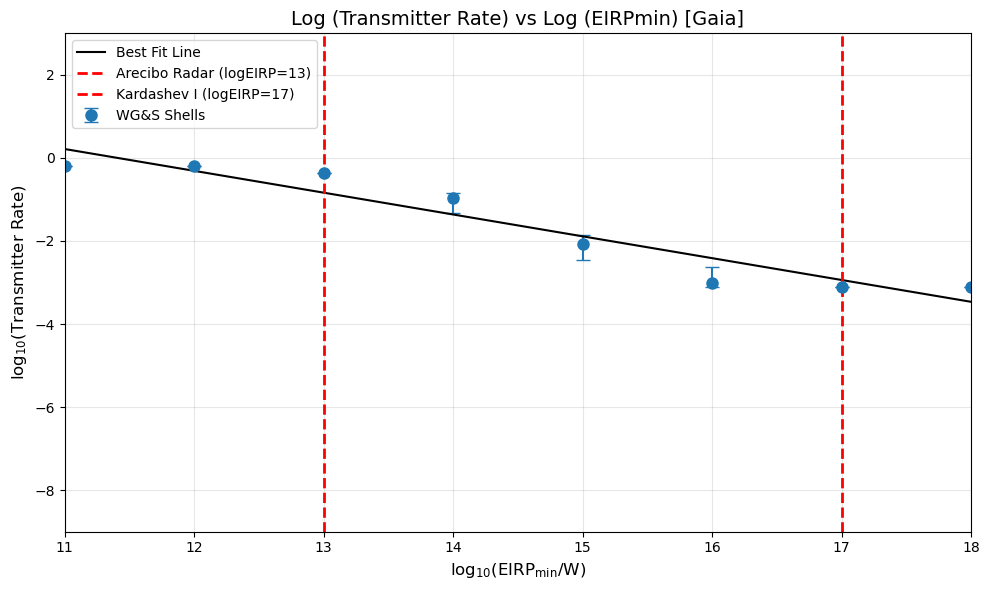

In [66]:
plot_transmitter_rate_vs_eirpmin_gaia(shell_results_gaia, nu_rel=0.769)

# SynthPop

In [67]:
import numpy as np
import pandas as pd

def process_synthpop_catalog(synth_df, beam_ra, beam_dec, fwhm_arcmin, fmin, nu_rel,
    log_eirp_shells=np.linspace(11, 18, 8)):
    """
    Process SynthPop catalog for SETI beam analysis.
    Returns a DataFrame with cumulative shell counts and Poisson errors.
    """
    # 1. Calculate beam sensitivity metrics
    def angular_separation_arcmin(beam_ra, beam_dec, star_ras, star_decs):
        """
        Compute angular separation between two points (RA/Dec, degrees) in arcminutes.
        All inputs and output are floats.
        """
        # # Create a SkyCoord object in the Galactic frame
        # c_galactic = SkyCoord(l=l * u.deg, b=b * u.deg, frame='galactic')
    
        # # Transform to ICRS (RA, Dec)
        # c_icrs = c_galactic.transform_to('icrs')
    
        # # Access RA and Dec
        # ra_star = c_icrs.ra
        # dec_star = c_icrs.dec
    
        c1 = SkyCoord(beam_ra, beam_dec, unit='deg')
        c2 = SkyCoord(star_ras, star_decs, unit='deg')
        sep = c1.separation(c2)
        return sep.arcminute  # Output: float, arcminutes

    def beam_scaling(beam_ra, beam_dec, star_ras, star_decs, fwhm_arcmin):
        """
        Vectorized version: all inputs are NumPy arrays.
        Returns theta_arcmin, scaling_factor, eirp_boost as arrays.
        """
        theta_arcmin = angular_separation_arcmin(beam_ra, beam_dec, star_ras, star_decs)
        exponent = -4 * np.log(2) * (theta_arcmin / fwhm_arcmin)**2
        scaling_factor = np.exp(exponent)
        eirp_boost = np.where(scaling_factor > 0, 1.0 / scaling_factor, np.inf)
        return theta_arcmin, scaling_factor, eirp_boost
    
    def process_beam_astropy_vectorized(beam_ra, beam_dec, fwhm_arcmin, df):
        """
        Add beam sensitivity columns to existing DataFrame
        Inputs:
            beam_ra, beam_dec: Beam center (degrees)
            fwhm_arcmin: Beam width (arcminutes)
            df: DataFrame containing 'ra', 'dec'
        Returns: Modified DataFrame with new columns using SkyCoord
        Vectorized processing for large catalogs.
        """
        # Always work on a copy!
        df = df.copy()
        # Extract RA/Dec as numpy arrays
        star_ras = df['ra'].to_numpy()
        star_decs = df['dec'].to_numpy()
        
        # Compute metrics in bulk
        theta, scaling, eirp = beam_scaling(
        beam_ra, beam_dec, star_ras, star_decs, fwhm_arcmin)
        
        # Add results to DataFrame (no copying)
        df = df.copy()
        df.loc[:, 'theta_arcmin'] = theta
        df.loc[:, 'scaling_factor'] = scaling
        df.loc[:, 'eirp_boost'] = eirp
        return df
    synth_df = process_beam_astropy_vectorized(beam_ra, beam_dec, fwhm_arcmin, synth_df)

    # 2. Calculate log10(EIRPmin) for each star (to avoid overflow)
    def calculate_log_eirpmin(df, fmin):
        log_4pi = np.log10(4 * np.pi)
        d_m = df.loc[:, "Dist_pc"].to_numpy() * 3.086e16  # parsecs to meters
        df['logEIRPmin'] = log_4pi + 2 * np.log10(d_m) + np.log10(fmin) + np.log10(df['eirp_boost'])
        return df
    synth_df = calculate_log_eirpmin(synth_df, fmin)

    # 3. Cumulative shell analysis
    def analyze_shells_with_uncertainty_cumulative_log_synth(df, log_eirp_shells, fmin, nu_rel):
        results = []
        for log_shell_val in log_eirp_shells:
            shell_val = 10**log_shell_val
            n_stars = np.sum(df['logEIRPmin'] <= log_shell_val)
            n_stars_err = np.sqrt(n_stars) # if n_stars > 0 else np.nan
            cwtfm = (shell_val / 1e13) * (0.5 / nu_rel) * (1000 / n_stars) if n_stars > 0 else np.nan
            # Poisson error propagation for CWTFM
            cwtfm_err = cwtfm * (n_stars_err / n_stars) if n_stars > 0 else np.nan
            results.append({
                'EIRPmin_shell': shell_val,
                'n_stars': n_stars,
                'n_stars_err': n_stars_err,
                'CWTFM': cwtfm,
                'CWTFM_err': cwtfm_err
            })
        return pd.DataFrame(results)
    shell_results_synth = analyze_shells_with_uncertainty_cumulative_log_synth(synth_df, log_eirp_shells, fmin, nu_rel)
    return synth_df, shell_results_synth

    # my_dict = {'processed_catalog': synth_df, 'shell_analysis': shell_results}
    # return my_dict

In [68]:
import numpy as np
import matplotlib.pyplot as plt

def plot_transmitter_rate_vs_eirpmin_synthpop(shell_results, nu_rel=0.5):
    """
    Plot log(Transmitter Rate) vs log(EIRPmin) for SynthPop,
    with symmetric Poisson error bars, best-fit line, and vertical reference lines.
    """
    # Extract data
    eirp_shells = shell_results['EIRPmin_shell'].to_numpy()
    n_stars = shell_results['n_stars'].to_numpy()
    n_stars_err = shell_results['n_stars_err'].to_numpy()

    # Calculate transmitter rate and its symmetric errors
    with np.errstate(divide='ignore', invalid='ignore'):
        transmitter_rate = np.where(n_stars > 0, 1.0 / (n_stars * nu_rel), np.nan)
        n_stars_upper = n_stars + n_stars_err
        n_stars_lower = n_stars - n_stars_err

        transmitter_rate_pos = np.where(n_stars_lower > 0, 1.0 / (n_stars_lower * nu_rel), np.nan)
        transmitter_rate_neg = np.where(n_stars_upper > 0, 1.0 / (n_stars_upper * nu_rel), np.nan)

        # Symmetric error: average of |up-down|
        yerr_pos = transmitter_rate_pos - transmitter_rate
        yerr_neg = transmitter_rate - transmitter_rate_neg

        # Log values for plotting
        log_eirp = np.log10(eirp_shells)
        log_transmitter_rate = np.log10(transmitter_rate)
        # For error bars, use differences in log space
        log_yerr_pos = np.log10(transmitter_rate_pos) - log_transmitter_rate
        log_yerr_neg = log_transmitter_rate - np.log10(transmitter_rate_neg)

    # Mask for finite values and n_stars > 0
    mask = np.isfinite(log_eirp) & np.isfinite(log_transmitter_rate) & (n_stars > 0)
    x = log_eirp[mask]
    y = log_transmitter_rate[mask]
    yerr = np.array([log_yerr_neg[mask], log_yerr_pos[mask]])

    # Fit a line (excluding nan/infs)
    if len(x) > 1:
        fit = np.polyfit(x, y, 1)
        fit_line = np.polyval(fit, x)
    else:
        fit = [np.nan, np.nan]
        fit_line = np.full_like(x, np.nan)

    fig, ax = plt.subplots(figsize=(10, 6))
    # Asymmetric error bars: use yerr as [[neg], [pos]]
    ax.errorbar(
        x, y, yerr=yerr,
        fmt='o', capsize=5, markersize=8, label='SynthPop Shells'
    )
    if len(x) > 1:
        ax.plot(x, fit_line, 'k-', label='Best Fit Line')
    ax.axvline(13, color='red', linestyle='--', lw=2, label='Arecibo Radar (logEIRP=13)')
    ax.axvline(17, color='red', linestyle='--', lw=2, label='Kardashev I (logEIRP=17)')
    ax.set_xlabel('log$_{10}$(EIRP$_{\\mathrm{min}}$/W)', fontsize=12)
    ax.set_ylabel('log$_{10}$(Transmitter Rate)', fontsize=12)
    ax.set_title('Log (Transmitter Rate) vs Log (EIRPmin) [SynthPop]', fontsize=14)
    ax.set_xlim(11, 18)
    ax.set_ylim(-9, 3)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [69]:
synth_df, shell_results_synth = process_synthpop_catalog(synth_df, 296.382669, 33.565181, 5.5, 1e-26, 0.769, log_eirp_shells=np.linspace(11, 18, 8))

In [70]:
synth_df

,pop,iMass,age,Fe/H_initial,Mass,In_Final_Phase,Dist,ra,dec,vr_bc,...,Bessell_I,Gaia_G_EDR3,Gaia_BP_EDR3,Gaia_RP_EDR3,Dim_Compact_Object_Flag,Dist_pc,theta_arcmin,scaling_factor,eirp_boost,logEIRPmin
0,0.0,0.258981,10.000000,0.172152,0.258977,0.0,2.304841,296.432007,33.568863,91.952731,...,22.968323,24.823030,27.088561,23.220127,0.0,2304.840591,2.476501,0.569994,1.754406,15.047414
1,0.0,0.225304,10.000000,0.136073,0.225301,0.0,2.825339,296.404985,33.577649,-71.113543,...,23.753084,25.608455,27.936062,23.997384,0.0,2825.338579,1.343227,0.847579,1.179831,15.051962
2,0.0,0.427146,10.000000,-0.002382,0.427136,0.0,3.403819,296.349726,33.542729,-31.014018,...,21.879786,23.479813,25.052112,22.108918,0.0,3403.818553,2.127929,0.660324,1.514409,15.322178
3,0.0,0.496132,10.000000,0.002717,0.496117,0.0,3.623803,296.391433,33.524754,49.946717,...,21.514202,23.046590,24.530694,21.722600,0.0,3623.802854,2.464891,0.572999,1.745205,15.438177
4,0.0,0.404243,10.000000,0.094227,0.404235,0.0,3.874068,296.340978,33.550233,138.235131,...,22.419577,24.092626,25.784935,22.667416,0.0,3874.067657,2.269285,0.623756,1.603190,15.459321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39817,10.0,0.393340,9.816897,-0.185782,0.393331,0.0,24.810263,296.375288,33.544310,-252.054357,...,26.324193,27.879983,29.404716,26.536608,0.0,24810.263130,1.305516,0.855375,1.169078,16.935108
39818,10.0,0.094051,7.927878,-0.346029,0.094051,0.0,24.955579,296.402569,33.597922,-251.449002,...,NaN,NaN,NaN,NaN,0.0,24955.579386,2.201926,0.641215,1.559540,17.065334
39819,10.0,0.175978,9.789717,-0.181730,0.175975,0.0,24.961544,296.354160,33.569158,-246.807520,...,28.258906,29.994567,31.819910,28.518946,0.0,24961.543842,1.445127,0.825791,1.210960,16.955674
39820,10.0,0.424295,9.213073,-0.368047,0.424285,0.0,24.913853,296.393282,33.583826,-167.966244,...,25.991801,27.459218,28.881691,26.175691,0.0,24913.852954,1.238139,0.868917,1.150857,16.931905


In [97]:
shell_results_synth

,EIRPmin_shell,n_stars,n_stars_err,CWTFM,CWTFM_err
0,1.000000e+11,0,0.000000,NaN,NaN
1,1.000000e+12,0,0.000000,NaN,NaN
2,1.000000e+13,1,1.000000,650.195059,650.195059
3,1.000000e+14,47,6.855655,138.339374,20.178872
4,1.000000e+15,1242,35.242020,52.350649,1.485461
5,1.000000e+16,14380,119.916638,45.215234,0.377056
6,1.000000e+17,39134,197.823153,166.145822,0.839870
7,1.000000e+18,39822,199.554504,1632.753399,8.181992


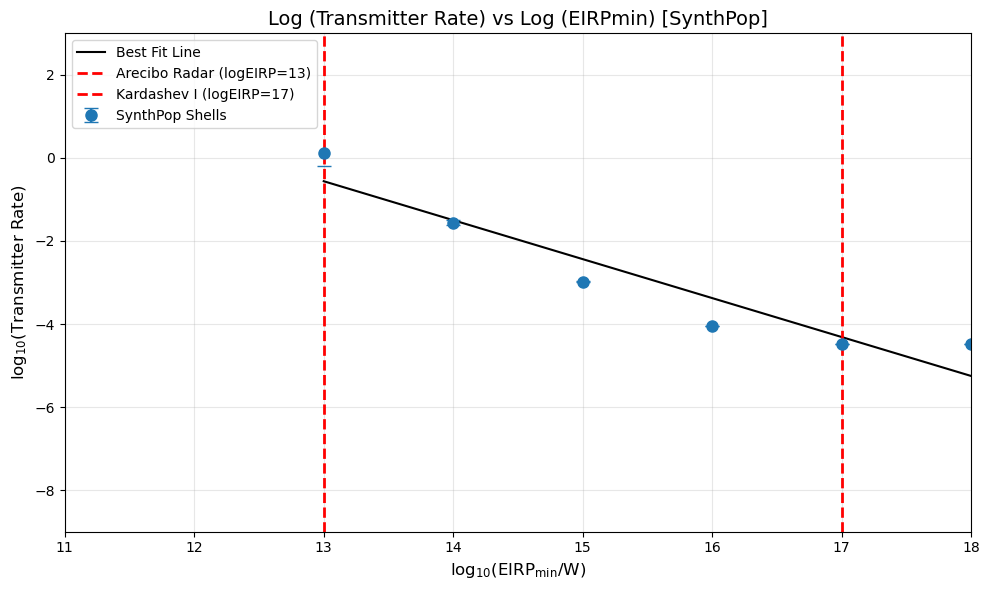

In [51]:
plot_transmitter_rate_vs_eirpmin_synthpop(shell_results_synth, nu_rel=0.769)

In [78]:
from scipy.stats import linregress

log_eirp = np.log10(shell_results_synth.loc[2:, "EIRPmin_shell"].to_numpy())  # Exclude 0 N_stars entries
n_stars_gaia = shell_results_gaia.loc[2:, "n_stars"].to_numpy()
n_stars_synth = shell_results_synth.loc[2:, "n_stars"].to_numpy()
log_rate_gaia = np.log10(1 / (n_stars_gaia * 0.769))
log_rate_synth = np.log10(1 / (n_stars_synth * 0.769))

result_gaia = linregress(log_eirp, log_rate_gaia)
result_synth = linregress(log_eirp, log_rate_synth)

In [91]:
result_gaia.slope

np.float64(-0.6039358684827789)

In [92]:
result_synth.slope

np.float64(-0.937874907958392)

# Ratio of n_stars (SynthPop/Gaia) per Shell

In [93]:
def ratio_nstars(synthpop_shells, gaia_shells):
    """
    Compute the ratio of n_stars (SynthPop / Gaia) for each EIRPmin shell.
    """
    df = pd.merge(
        synthpop_shells[['EIRPmin_shell', 'n_stars']],
        gaia_shells[['EIRPmin_shell', 'n_stars']],
        on='EIRPmin_shell', suffixes=('_synth', '_gaia')
    )
    df['ratio'] = df.apply(
        lambda row: row['n_stars_synth'] / row['n_stars_gaia'] if row['n_stars_gaia'] > 0 else np.nan,
        axis=1
    )
    return df[['EIRPmin_shell', 'ratio']]


In [94]:
ratio_nstars(shell_results_synth, shell_results_gaia)

,EIRPmin_shell,ratio
0,1.000000e+11,0.000000
1,1.000000e+12,0.000000
2,1.000000e+13,0.333333
3,1.000000e+14,3.916667
4,1.000000e+15,8.225166
5,1.000000e+16,10.885693
6,1.000000e+17,23.183649
7,1.000000e+18,23.591232


# Error Bar Comparison

In [106]:
import pandas as pd
import numpy as np

def compare_error_bars(synthpop_shells, gaia_shells):
    """
    Compare relative errors in n_stars and CWTFM between SynthPop and Gaia.

    Inputs:
        synthpop_shells (pd.DataFrame): DataFrame containing SynthPop shell data
                                        with 'EIRPmin_shell', 'n_stars', 'n_stars_err',
                                        'CWTFM', 'CWTFM_err' columns.
        gaia_shells (pd.DataFrame): DataFrame containing Gaia shell data
                                    with 'EIRPmin_shell', 'n_stars', 'n_stars_pos_err',
                                    'n_stars_neg_err', 'CWTFM', 'CWTFM_pos_err',
                                    'CWTFM_neg_err' columns.

    Outputs:
        pd.DataFrame: A new DataFrame with 'EIRPmin_shell' and relative error
                      columns for n_stars and CWTFM for both SynthPop and Gaia.
    """
    # Merge the two dataframes on 'EIRPmin_shell'
    # Columns with the same name will be suffixed: _synth for synthpop, _gaia for gaia
    df = pd.merge(
        synthpop_shells[['EIRPmin_shell', 'n_stars', 'n_stars_err', 'CWTFM', 'CWTFM_err']],
        gaia_shells[['EIRPmin_shell', 'n_stars', 'n_stars_pos_err', 'n_stars_neg_err', 'CWTFM', 'CWTFM_pos_err', 'CWTFM_neg_err']],
        on='EIRPmin_shell',
        suffixes=('_synth', '_gaia')
    )

    # Calculate relative error for n_stars (SynthPop)
    df['rel_err_nstars_synth'] = np.where(
        df['n_stars_synth'] > 0,
        df['n_stars_err'] / df['n_stars_synth'], # Corrected: 'n_stars_err' not 'n_stars_err_synth'
        np.nan
    )

    # Calculate relative error for CWTFM (SynthPop)
    df['rel_err_cwtfm_synth'] = np.where(
        df['CWTFM_synth'] > 0,
        df['CWTFM_err'] / df['CWTFM_synth'], # Corrected: 'CWTFM_err' not 'CWTFM_err_synth'
        np.nan
    )

    # Calculate relative error for n_stars (Gaia)
    df['rel_err_nstars_gaia'] = np.where(
        df['n_stars_gaia'] > 0,
        ((df['n_stars_pos_err'] + df['n_stars_neg_err']) / 2) / df['n_stars_gaia'], # No suffix on pos/neg errors
        np.nan
    )

    # Calculate relative error for CWTFM (Gaia)
    df['rel_err_cwtfm_gaia'] = np.where(
        df['CWTFM_gaia'] > 0,
        ((df['CWTFM_pos_err'] + df['CWTFM_neg_err']) / 2) / df['CWTFM_gaia'], # No suffix on pos/neg errors
        np.nan
    )
    # Return only the relevant columns
    return df[['EIRPmin_shell', 'rel_err_nstars_synth', 'rel_err_nstars_gaia', 'rel_err_cwtfm_synth', 'rel_err_cwtfm_gaia']]


In [107]:
compare_error_bars(shell_results_synth, shell_results_gaia)

,EIRPmin_shell,rel_err_nstars_synth,rel_err_nstars_gaia,rel_err_cwtfm_synth,rel_err_cwtfm_gaia
0,1.000000e+11,NaN,0.000000,NaN,0.000000
1,1.000000e+12,NaN,0.000000,NaN,0.000000
2,1.000000e+13,1.000000,0.000000,1.000000,0.000000
3,1.000000e+14,0.145865,0.750000,0.145865,0.444444
4,1.000000e+15,0.028375,0.894040,0.028375,0.603839
5,1.000000e+16,0.008339,0.419379,0.008339,0.812350
6,1.000000e+17,0.005055,0.000296,0.005055,0.000296
7,1.000000e+18,0.005011,0.000000,0.005011,0.000000


# 6. Combined Pipeline Example

In [108]:
def compare_synthpop_gaia(synthpop_shells, gaia_shells):
    
    results = {}
    results['slope_synthpop'] = quantify_slope(synthpop_shells)
    results['slope_gaia'] = quantify_slope(gaia_shells)
    results['ratio_nstars'] = ratio_nstars(synthpop_shells, gaia_shells)
    results['cwtfm_min_synthpop'] = find_cwtfm_minima(synthpop_shells)
    results['cwtfm_min_gaia'] = find_cwtfm_minima(gaia_shells)
    results['error_comparison'] = compare_error_bars(synthpop_shells, gaia_shells)
    results['n_stars_plateaus_synthpop'] = find_plateaus(synthpop_shells, 'n_stars')
    results['n_stars_plateaus_gaia'] = find_plateaus(gaia_shells, 'n_stars')
    results['cwtfm_plateaus_synthpop'] = find_plateaus(synthpop_shells, 'CWTFM')
    results['cwtfm_plateaus_gaia'] = find_plateaus(gaia_shells, 'CWTFM')
    return results


# Call the functions above to quantify slopes, ratios, minima, error bars, and plateaus. ***************